# Active Learning


With the growth of data-centric Machine Learning, Active Learning has grown in popularity amongst businesses and researchers. Active Learning seeks to progressively train ML models so that the resultant model requires lesser amount of training data to achieve competitive scores.

The structure of an Active Learning pipeline involves a classifier and an oracle. The oracle is an annotator that cleans, selects, labels the data, and feeds it to the model when required. The oracle is a trained individual or a group of individuals that ensure consistency in labeling of new data.

The process starts with annotating a small subset of the full dataset and training an initial model. The best model checkpoint is saved and then tested on a balanced test set. The test set must be carefully sampled because the full training process will be dependent on it. Once we have the initial evaluation scores, the oracle is tasked with labeling more samples; the number of data points to be sampled is usually determined by the business requirements. After that, the newly sampled data is added to the training set, and the training procedure repeats. This cycle continues until either an acceptable score is reached or some other business metric is met.

This tutorial provides a basic demonstration of how Active Learning works by demonstrating a ratio-based (least confidence) sampling strategy that results in lower overall false positive and negative rates when compared to a model trained on the entire dataset. This sampling falls under the domain of uncertanity sampling, in which new datasets are sampled based on the uncertanity that the model outputs for the corresponding label. In our example, we compare our model's false positive and false negative rates and annotate the new data based on their ratio.

Some other sampling techniques include:

1. Committee sampling: Using multiple models to vote for the best data points to be sampled
2. Entropy reduction: Sampling according to an entropy threshold, selecting more of the samples that produce the highest entropy score.
3. Minimum margin based sampling: Selects data points closest to the decision boundary

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import re
import string

tfds.disable_progress_bar()

### Loading and preprocessing the data

We will be using the IMDB reviews dataset for our experiments. This dataset has 50,000 reviews in total, including training and testing splits. We will merge these splits and sample our own, balanced training, validation and testing sets.

In [2]:
dataset = tfds.load(
    "imdb_reviews",
    split="train + test",
    as_supervised=True,
    batch_size=-1,
    shuffle_files=False,
)
reviews, labels = tfds.as_numpy(dataset)

print("Total examples:", reviews.shape[0])

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Total examples: 50000


Active learning starts with labeling a subset of data. For the ratio sampling technique that we will be using, we will need well-balanced training, validation and testing splits.

In [3]:
val_split = 2500
test_split = 2500
train_split = 7500

In [4]:
# Separating the negative and positive samples for manual stratification
x_positives, y_positives = reviews[labels == 1], labels[labels == 1]
x_negatives, y_negatives = reviews[labels == 0], labels[labels == 0]

In [6]:
# Creating training, validation and testing splits
x_val, y_val = (
    tf.concat((x_positives[:val_split], x_negatives[:val_split]), 0),
    tf.concat((y_positives[:val_split], y_negatives[:val_split]), 0),
)

x_test, y_test = (
    tf.concat(
        (
            x_positives[val_split : val_split + test_split],
            x_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split : val_split + test_split],
            y_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
)
x_train, y_train = (
    tf.concat(
        (
            x_positives[val_split + test_split : val_split + test_split + train_split],
            x_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split + test_split : val_split + test_split + train_split],
            y_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
)

In [7]:
# Remaining pool of samples are stored separately. These are only labeled as and when required
x_pool_positives, y_pool_positives = (
    x_positives[val_split + test_split + train_split :],
    y_positives[val_split + test_split + train_split :],
)
x_pool_negatives, y_pool_negatives = (
    x_negatives[val_split + test_split + train_split :],
    y_negatives[val_split + test_split + train_split :],
)

In [8]:
# Creating TF Datasets for faster prefetching and parallelization
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

pool_negatives = tf.data.Dataset.from_tensor_slices(
    (x_pool_negatives, y_pool_negatives)
)
pool_positives = tf.data.Dataset.from_tensor_slices(
    (x_pool_positives, y_pool_positives)
)

print(f"Initial training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")
print(f"Unlabeled negative pool: {len(pool_negatives)}")
print(f"Unlabeled positive pool: {len(pool_positives)}")

Initial training set size: 15000
Validation set size: 5000
Testing set size: 5000
Unlabeled negative pool: 12500
Unlabeled positive pool: 12500


### Fitting the TextVectorization layer
Since we are working with text data, we will need to encode the text strings as vectors which would then be passed through an Embedding layer. To make this tokenization process faster, we use the map() function with its parallelization functionality.

In [9]:
# Define custom standardization function - 
# lower the text, remove line breaks, remove punctuations
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )


# Create a vectorization layer, with max_features=3000, 
# custom standardizer and output seq len = 150
vectorizer = layers.TextVectorization(
    3000, standardize=custom_standardization, output_sequence_length=150
)

# Adapting on the training dataset
# This means that the vectorizer will use the vocab from training dataset
vectorizer.adapt(
    train_dataset.map(lambda x, y: x, num_parallel_calls=tf.data.AUTOTUNE).batch(256)
)

# Create the function to map
def vectorize_text(text, label):
    text = vectorizer(text)
    return text, label

# Map the vectorizer function on train, test and val datasets
# Regarding num_parallel_calls : A tf.int64 scalar tf.Tensor, 
# representing the number of batches to compute asynchronously in parallel. 
# If not specified, batches will be computed sequentially. 
# If the value tf.data.AUTOTUNE is used, then the number of parallel calls is
# set dynamically based on available resources
train_dataset = train_dataset.map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)

test_dataset = test_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)

# Map the vectorizer function on unlabelled positives and negatives
pool_negatives = pool_negatives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
pool_positives = pool_positives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

### Creating Helper Functions

In [11]:
# Helper function for merging new history objects with older ones
def append_history(losses, val_losses, accuracy, val_accuracy, history):
    losses = losses + history.history["loss"]
    val_losses = val_losses + history.history["val_loss"]
    accuracy = accuracy + history.history["binary_accuracy"]
    val_accuracy = val_accuracy + history.history["val_binary_accuracy"]
    return losses, val_losses, accuracy, val_accuracy

# Plotter function
def plot_history(losses, val_losses, accuracies, val_accuracies):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

### Creating the Model
We create a small bidirectional LSTM model. When using Active Learning, you should make sure that the model architecture is capable of overfitting to the initial data. Overfitting gives a strong hint that the model will have enough capacity for future, unseen data.

In [12]:
def create_model():
    model = keras.models.Sequential(
        [
            layers.Input(shape=(150,)), 
            layers.Embedding(input_dim=3000, output_dim=128),
            layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
            layers.GlobalMaxPool1D(),
            layers.Dense(20, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.summary()
    return model

### Training on the entire dataset
To show the effectiveness of Active Learning, we will first train the model on the entire dataset containing 40,000 labeled samples. This model will be used for comparison later.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 128)          384000    
                                                                 
 bidirectional (Bidirectiona  (None, 150, 64)          41216     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

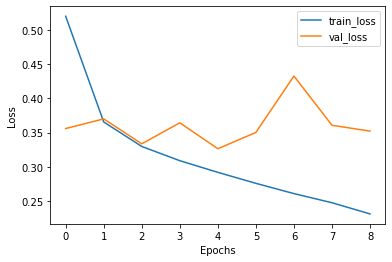

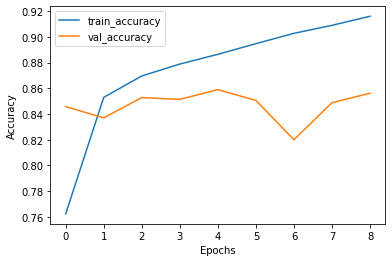

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'loss': 0.3378961682319641, 'binary_accuracy': 0.8543999791145325, 'false_negatives': 443.0, 'false_positives': 285.0}
----------------------------------------------------------------------------------------------------


In [14]:
def train_full_model(full_train_dataset, val_dataset, test_dataset):
    model = create_model()
    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop",
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.FalseNegatives(),
            keras.metrics.FalsePositives(),
        ],
    )

    # We will save the best model at every epoch and load the best one for evaluation on the test set
    history = model.fit(
        full_train_dataset.batch(256),
        epochs=20,
        validation_data=val_dataset,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=4, verbose=1),
            keras.callbacks.ModelCheckpoint(
                "FullModelCheckpoint.h5", verbose=1, save_best_only=True
            ),
        ],
    )

    # Plot history
    plot_history(
        history.history["loss"],
        history.history["val_loss"],
        history.history["binary_accuracy"],
        history.history["val_binary_accuracy"],
    )

    # Loading the best checkpoint
    model = keras.models.load_model("FullModelCheckpoint.h5")

    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)
    return model


# Sampling the full train dataset to train on
full_train_dataset = (
    train_dataset.concatenate(pool_positives)
    .concatenate(pool_negatives)
    .cache()
    .shuffle(20000)
)

# Training the full model
full_dataset_model = train_full_model(full_train_dataset, val_dataset, test_dataset)